### 3.  Preprocessing & Modelling - Regression Modelling

This notebook explores the prediction of number of mosquitos to be used as a feature in predicting the probability of virus.

### Contents:
- [Import Libraries](#Import-Libraries)
- [Import Data](#Import-Data)
- [Data prepared for Modelling](#Data-prepared-for-Modelling)
- [Modelling](#Modelling)
- [Model Evaluation](#Model-Evaluation)

### Import Libraries

We import the necessary libraries used in analysis.

In [46]:
# import libraries

# maths
import numpy as np
import pandas as pd

# visual
#from matplotlib_venn import venn2
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# modelling
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.utils import resample, shuffle
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

# Others
import warnings
warnings.filterwarnings("ignore")
from IPython.display import Image

### Import Data

The cleaned datasets are imported.

In [2]:
# file paths

input_path = '../data/2_input/'
clean_path = '../data/3_clean/'
output_path = '../data/4_output/'

image_path = '../images/'

In [3]:
# import clean data

df_train = pd.read_csv(clean_path + 'train_clean.csv')
df_test = pd.read_csv(clean_path + 'test_clean.csv')
df_weather = pd.read_csv(clean_path + 'weather_clean.csv')

In [4]:
print('Size of train dataset: {}'.format(df_train.shape))
print('Size of test dataset: {}'.format(df_test.shape))
print('Size of weather dataset: {}'.format(df_weather.shape))

Size of train dataset: (8475, 11)
Size of test dataset: (116293, 10)
Size of weather dataset: (2944, 20)


### Data prepared for Modelling

We combine train and test data to prepare the datasets for modelling.

In [5]:
#Drops id column from test not in train
test = df_test.drop('id', axis=1)
#Drops nummosquitos and wnvpresent columns from train not in test
train = df_train.drop(['nummosquitos', 'wnvpresent'], axis=1)

#Combines train and test datasets
combined_train_test = pd.concat([test,train])

print('Size of train/test dataset: {}'.format(combined_train_test.shape))

Size of train/test dataset: (124768, 9)


We split the data from each station and use only the data from Station 1 here, considering that there were many null values in Station 2 which we imputed from Station 1 data when cleaning the data.
We then, merge the Station 1 weather data with the train/test dataset to add information on weather conditions as measured at Station 1 on the dates of virus test.

In [6]:
#Splits weather data by Station
only_station_1 = df_weather[df_weather['station'] == 1].reset_index(drop=True)

In [7]:
#Combines weather data with train and test dataset
all_dataset = combined_train_test.merge(only_station_1, how='left', on=['year','month','day'])

print('Size of train/test dataset with weather data: {}'.format(all_dataset.shape))

Size of train/test dataset with weather data: (124768, 26)


In [8]:
#Prints train/test dataset with weather information
all_dataset.head()

,species,block,street,trap,latitude,longitude,year,month,day,station,...,heat,cool,sunrise,sunset,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed
0,CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,41.95469,-87.800991,2008,6,11,1,...,0,9,416,1926,0.0,29.28,29.99,8.9,18,10.0
1,CULEX RESTUANS,41,N OAK PARK AVE,T002,41.95469,-87.800991,2008,6,11,1,...,0,9,416,1926,0.0,29.28,29.99,8.9,18,10.0
2,CULEX PIPIENS,41,N OAK PARK AVE,T002,41.95469,-87.800991,2008,6,11,1,...,0,9,416,1926,0.0,29.28,29.99,8.9,18,10.0
3,CULEX SALINARIUS,41,N OAK PARK AVE,T002,41.95469,-87.800991,2008,6,11,1,...,0,9,416,1926,0.0,29.28,29.99,8.9,18,10.0
4,CULEX TERRITANS,41,N OAK PARK AVE,T002,41.95469,-87.800991,2008,6,11,1,...,0,9,416,1926,0.0,29.28,29.99,8.9,18,10.0


In [9]:
#Converts categorical data into numeric
df_get_dum = pd.concat([all_dataset, pd.get_dummies(all_dataset[['species', 'street', 'trap']],drop_first=True)], axis=1)
df_get_dum.drop(['species', 'street', 'trap'], inplace =True, axis=1)

print('Size of train/test dataset with weather data(One Hot Encoded): {}'.format(df_get_dum.shape))

Size of train/test dataset with weather data(One Hot Encoded): (124768, 316)


We drop 'block' as the information is used to derive the latitude and longitude.

In [10]:
# drop 'block' column
df_get_dum.drop(['block'], inplace =True, axis=1)
print('Size of train/test dataset with weather data(after dropping block): {}'.format(df_get_dum.shape))

Size of train/test dataset with weather data(after dropping block): (124768, 315)


We split the data back into seperate train and test datasets and only use train for training the model.

In [11]:
#Splits out train dataset using year
train = df_get_dum[df_get_dum['year']%2!=0]
train.reset_index(inplace=True, drop=True)

#Re-attaching original nummosquitos and wnvpresent columns
wnv = pd.Series(df_train['wnvpresent'])
train_with_wnv = pd.concat([train , wnv], axis=1)
train_with_wnv['nummosquitos'] = df_train['nummosquitos']

print('Size of processed train data: {}'.format(train_with_wnv.shape))

Size of processed train data: (8475, 317)


In [12]:
#Splits out test dataset using year
test = df_get_dum.loc[df_get_dum['year']%2==0]
print('Size of processed test data: {}'.format(test.shape))

Size of processed train data: (116293, 315)


We also note that the data is imbalanced. Out of the 8475 rows in our training dataset, only 457 (~5%) data points represent the virus present class while 8018 represent virus not present. 

The method to handle the imbalanced data is the same as the main modelling notebook (3. Preprocessing & Modelling)

In [13]:
#Splits data by presence of wnv
majority_class = train_with_wnv[train_with_wnv['wnvpresent']==0]
minority_class = train_with_wnv[train_with_wnv['wnvpresent']==1]

#Resamples minority class with replacement
minority_upsampled = resample( minority_class, replace=True, n_samples=majority_class.shape[0], random_state=42)

#Combine new minority class dataset with original majority class dataset
train_resampled = pd.concat([minority_upsampled,majority_class])

#Checks class representation
train_resampled.wnvpresent.value_counts()

1    8018
0    8018
Name: wnvpresent, dtype: int64

In [14]:
#Shuffles dataset to inject randomness
df = shuffle(train_resampled, random_state=42)
df.reset_index(drop=True, inplace=True)

# Print resampled, reshuffled new dataset
df.head()

,latitude,longitude,year,month,day,station,tmax,tmin,tavg,depart,...,trap_T233,trap_T234,trap_T235,trap_T236,trap_T237,trap_T238,trap_T900,trap_T903,wnvpresent,nummosquitos
0,41.721474,-87.648064,2007,7,11,1,77,62,70,-3,...,0,0,0,0,0,0,0,0,0,15
1,41.963976,-87.691810,2013,9,6,1,86,57,72,5,...,0,0,0,0,0,0,0,0,1,82
2,41.944869,-87.832763,2007,8,24,1,80,69,75,4,...,0,0,0,0,0,0,0,0,1,9
3,41.759346,-87.745602,2007,10,4,1,82,51,67,10,...,0,0,0,0,0,0,0,0,0,11
4,41.726465,-87.585413,2011,6,24,1,68,60,64,-7,...,0,0,0,0,0,0,0,0,0,1


### Modelling

#### Predict number of mosquitos

We use all the features in the dataset to fit regression models and identify nummosquitos to be our target.

In [15]:
X = df.drop(columns=['nummosquitos', 'wnvpresent'])
y = df.nummosquitos

# data is split randomly into train and test subsets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

We fit the model on the following regressions and test its performance using R2 score: 
- Linear Regression, 
- Ridge, 
- Lasso, 
- Elastic Net,
- Random Forest Regressor

In [16]:
estimators = {
    'linreg': LinearRegression(),
    'ridge': Ridge(),
    'lasso': Lasso(),
    'en': ElasticNet(),
    'rfr': RandomForestRegressor()
}.items()

for k,v in estimators:
    pipe = Pipeline([
        ('sc', StandardScaler()),
        (k,v)])
    model = pipe.fit(X_train,y_train)
    print('{} score: {}, Cross Validation Mean: {}, Cross Validation Std Dev: {}'.format(k, model.score(X_train,y_train), round(cross_val_score(model,X,y,cv=3).mean(),5), round(cross_val_score(model,X,y,cv=3).std(),5)))

linreg score: 0.36101866159604734, Cross Validation Mean: -9.842090054421616e+20, Cross Validation Std Dev: 1.39188172370604e+21
ridge score: 0.3687198011088615, Cross Validation Mean: 0.35268, Cross Validation Std Dev: 0.03028
lasso score: 0.36058636616687845, Cross Validation Mean: 0.34691, Cross Validation Std Dev: 0.02835
en score: 0.34384227815412605, Cross Validation Mean: 0.33436, Cross Validation Std Dev: 0.01303
rfr score: 0.9884274002419923, Cross Validation Mean: 0.93288, Cross Validation Std Dev: 0.02605


Using the default parameters, the R2 scores for all models are very low except for random forest regressor. As random forest regressor is a bagging technique, the aggregation of regression of random features will produce the highest score. As such, we chose to focus on random forest regressor to tune the hyperparameters and take a look at the features that are more important.

In [17]:
# Random Forest Regressor has the highest score in predicting the number of mosquitos. 
pipe = Pipeline([
        ('sc', StandardScaler()),
        ('rfr', RandomForestRegressor(n_estimators=20))
         ])

params = {'rfr__n_estimators': [10, 30, 50, 100]}

gridsearch = GridSearchCV(
        estimator=pipe,
        param_grid=params,
        verbose=1,
        n_jobs=3,
    )

gridsearch.fit(X_train, y_train)
    
model = gridsearch.best_estimator_
score = model.score(X_test, y_test)
best_params = gridsearch.best_params_

# print results
print("Best parameters:", best_params)
print("Best R2 score:", gridsearch.best_score_)
print("Test R2 score:", score)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  12 out of  12 | elapsed:  3.8min finished


Best parameters: {'rfr__n_estimators': 30}
Best R2 score: 0.9452634371291879
Test R2 score: 0.9404392071962216


In [18]:
regressor = model.named_steps['rfr']

fi = pd.DataFrame({
    'features': X.columns,
    'importances': regressor.feature_importances_})

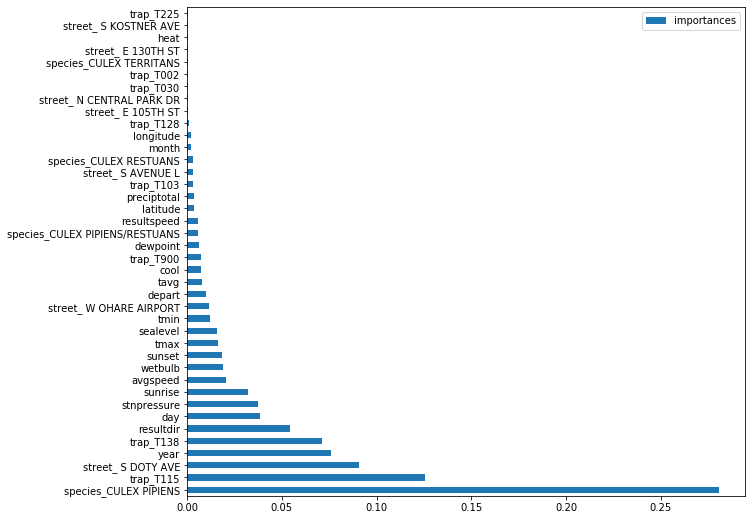

In [19]:
fig = fi.sort_values(by='importances', ascending=False).iloc[:40]
fig.plot(kind='barh', figsize=(10,9))
plt.yticks(range(len(fig)),fig['features'])
plt.show()

From the plot above, the feature importance becomes very small after the 31st feature. Hence, we will take the top 31 features for Random forest regressor model.

In [21]:
features1 = list(fig.head(31).features)
features1

['species_CULEX PIPIENS',
 'trap_T115',
 'street_ S DOTY AVE',
 'year',
 'trap_T138',
 'resultdir',
 'day',
 'stnpressure',
 'sunrise',
 'avgspeed',
 'wetbulb',
 'sunset',
 'tmax',
 'sealevel',
 'tmin',
 'street_ W OHARE AIRPORT',
 'depart',
 'tavg',
 'cool',
 'trap_T900',
 'dewpoint',
 'species_CULEX PIPIENS/RESTUANS',
 'resultspeed',
 'latitude',
 'preciptotal',
 'trap_T103',
 'street_ S AVENUE L',
 'species_CULEX RESTUANS',
 'month',
 'longitude',
 'trap_T128']

In [22]:
X1 = df[features1]
X_train1 = X_train[features1]
X_test1 = X_test[features1]
 
pipe = Pipeline([
        ('sc', StandardScaler()),
        ('rfr', RandomForestRegressor(n_estimators=30))
         ])

model = pipe.fit(X_train1, y_train)
score = model.score(X_test1, y_test)

# print results
print("R2 score:", score)
print("Cross validation scores mean:", round(cross_val_score(model,X1,y,cv=3).mean(),5))
print("Cross validation scores std dev:", round(cross_val_score(model,X1,y,cv=3).std(),5))

R2 score: 0.9455725839310992
Cross validation scores mean: 0.93897
Cross validation scores std dev: 0.03011


The mean of the cross validation scores is close to the R2 score and the standard deviation is low, indicating that the model can be generalised to unseen data.

#### Prediction using kaggle test set

In [23]:
# selecting the features selected for kaggle test set
X_kaggle = test[features1]
X_kaggle.head()

,species_CULEX PIPIENS,trap_T115,street_ S DOTY AVE,year,trap_T138,resultdir,day,stnpressure,sunrise,avgspeed,...,species_CULEX PIPIENS/RESTUANS,resultspeed,latitude,preciptotal,trap_T103,street_ S AVENUE L,species_CULEX RESTUANS,month,longitude,trap_T128
0,0,0,0,2008,0,18,11,29.28,416,10.0,...,1,8.9,41.95469,0.0,0,0,0,6,-87.800991,0
1,0,0,0,2008,0,18,11,29.28,416,10.0,...,0,8.9,41.95469,0.0,0,0,1,6,-87.800991,0
2,1,0,0,2008,0,18,11,29.28,416,10.0,...,0,8.9,41.95469,0.0,0,0,0,6,-87.800991,0
3,0,0,0,2008,0,18,11,29.28,416,10.0,...,0,8.9,41.95469,0.0,0,0,0,6,-87.800991,0
4,0,0,0,2008,0,18,11,29.28,416,10.0,...,0,8.9,41.95469,0.0,0,0,0,6,-87.800991,0


In [24]:
# predicting number of mosquitos from kaggle test set
test['nummosquitos'] = model.predict(X_kaggle)
test['nummosquitos'] = test['nummosquitos'].map(lambda x:int(x))
test.head()

,latitude,longitude,year,month,day,station,tmax,tmin,tavg,depart,...,trap_T232,trap_T233,trap_T234,trap_T235,trap_T236,trap_T237,trap_T238,trap_T900,trap_T903,nummosquitos
0,41.95469,-87.800991,2008,6,11,1,86,61,74,7,...,0,0,0,0,0,0,0,0,0,21
1,41.95469,-87.800991,2008,6,11,1,86,61,74,7,...,0,0,0,0,0,0,0,0,0,8
2,41.95469,-87.800991,2008,6,11,1,86,61,74,7,...,0,0,0,0,0,0,0,0,0,4
3,41.95469,-87.800991,2008,6,11,1,86,61,74,7,...,0,0,0,0,0,0,0,0,0,6
4,41.95469,-87.800991,2008,6,11,1,86,61,74,7,...,0,0,0,0,0,0,0,0,0,6


#### Predict presence of west nile virus

We use all the features in the dataset to for classification and identify wnvpresent to be our target.

In [25]:
X = df.drop(columns=['wnvpresent'])
y = df.wnvpresent

# data is split randomly into train and test subsets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

We train a model using Random Forest Classifer and tune the hyperparameters with GridSearch.

In [26]:
params = {
    'n_estimators' : [10, 50, 100],
    'max_depth' : [3,9,15,20],
    'min_samples_split': np.linspace(0.1, 0.5, 5),
    'min_samples_leaf' : np.linspace(0.1, 0.5, 5),
    'max_features' : (20, 50, 200, None)
}

In [27]:
parameters = []
roc_auc = []

gridsearch = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=params,
    verbose=1,
    cv= 3,
    n_jobs=-1,
    return_train_score= True,
    scoring = 'roc_auc'
)

gridsearch.fit(X_train, y_train)

model = gridsearch.best_estimator_
cv_score = gridsearch.cv_results_
best_params = gridsearch.best_params_

# predict y
y_pred = pd.DataFrame(model.predict_proba(X_test), columns=['0','1'])

# print results
print("Best parameters:", best_params)
print("Best score:", gridsearch.best_score_)
print("AUC/ROC test:", roc_auc_score(y_test,y_pred['1']))
pd.set_option('display.max_rows', 750)
display(pd.DataFrame(cv_score, columns = cv_score.keys()), )


# append info to list
parameters.append(best_params)
roc_auc.append(roc_auc_score(y_test,y_pred['1']))

Fitting 3 folds for each of 1200 candidates, totalling 3600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   47.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 16.2min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 24.0min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 32.6min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 51.4min
[Parallel(n_jobs=-1)]: Done 3600 out of 3600 | elapsed: 64.3min finished


Best parameters: {'max_depth': 9, 'max_features': 50, 'min_samples_leaf': 0.1, 'min_samples_split': 0.2, 'n_estimators': 100}
Best score: 0.8858574213679112
AUC/ROC test: 0.8763953791490351


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,...,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.603754,0.089650,0.135413,0.026556,3,20,0.1,0.1,10,"{'max_depth': 3, 'max_features': 20, 'min_samp...",...,0.790032,0.804601,0.818995,0.031228,442,0.852066,0.807748,0.809922,0.823245,0.020398
1,1.525876,0.371301,0.227877,0.018653,3,20,0.1,0.1,50,"{'max_depth': 3, 'max_features': 20, 'min_samp...",...,0.837864,0.885302,0.862776,0.019440,144,0.853228,0.847847,0.889763,0.863613,0.018621
2,2.533944,0.198400,0.520813,0.136410,3,20,0.1,0.1,100,"{'max_depth': 3, 'max_features': 20, 'min_samp...",...,0.855026,0.845648,0.857279,0.010535,200,0.861216,0.866390,0.853144,0.860250,0.005451
3,1.119741,0.095750,0.140621,0.033755,3,20,0.1,0.2,10,"{'max_depth': 3, 'max_features': 20, 'min_samp...",...,0.794284,0.827356,0.798960,0.021524,489,0.768363,0.804004,0.831113,0.801160,0.025696
4,1.542908,0.120319,0.355298,0.035941,3,20,0.1,0.2,50,"{'max_depth': 3, 'max_features': 20, 'min_samp...",...,0.847853,0.860843,0.863564,0.014072,133,0.870233,0.858303,0.862751,0.863762,0.004923
5,2.674596,0.032693,0.538167,0.106679,3,20,0.1,0.2,100,"{'max_depth': 3, 'max_features': 20, 'min_samp...",...,0.850370,0.842806,0.852509,0.008922,236,0.851727,0.862438,0.852061,0.855409,0.004973
6,0.943782,0.162410,0.202147,0.061826,3,20,0.1,0.3,10,"{'max_depth': 3, 'max_features': 20, 'min_samp...",...,0.849156,0.798662,0.838103,0.028764,318,0.865816,0.856727,0.813800,0.845448,0.022684
7,1.364399,0.134282,0.394636,0.051185,3,20,0.1,0.3,50,"{'max_depth': 3, 'max_features': 20, 'min_samp...",...,0.863412,0.860617,0.860842,0.002013,160,0.843516,0.873825,0.863350,0.860230,0.012569
8,2.388451,0.243115,0.582462,0.107240,3,20,0.1,0.3,100,"{'max_depth': 3, 'max_features': 20, 'min_samp...",...,0.843700,0.852606,0.858075,0.014495,189,0.868415,0.856289,0.859612,0.861439,0.005116
9,1.145937,0.138674,0.169510,0.009833,3,20,0.1,0.4,10,"{'max_depth': 3, 'max_features': 20, 'min_samp...",...,0.764190,0.856190,0.816190,0.038508,449,0.812836,0.775234,0.852147,0.813406,0.031403


Standard Deviation of train score is low, indicating that the model is not overfitted.

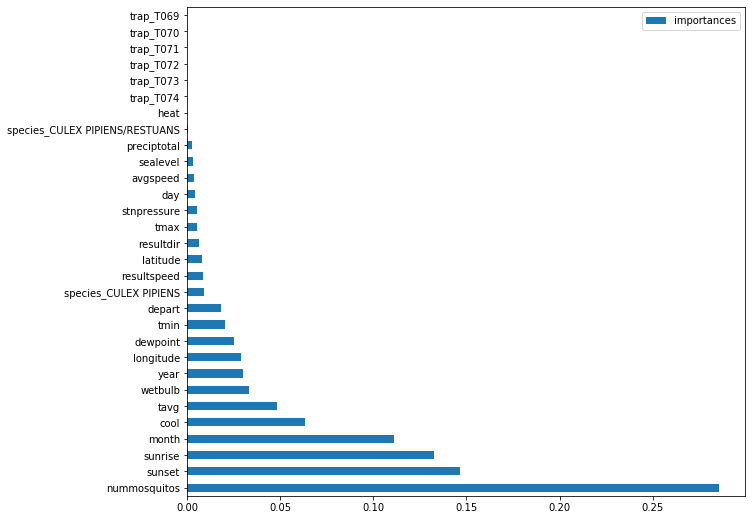

In [28]:
# visualise feature importances from the model
fi = pd.DataFrame({
    'features': X.columns,
    'importances': model.feature_importances_})
fig = fi.sort_values(by='importances', ascending=False).iloc[:30]
fig.plot(kind='barh', figsize=(10,9))
plt.yticks(range(len(fig)),fig['features'])
plt.show()

In [29]:
# csv for kaggle submission
features = list(X.columns)
test = test[features]

pred = pd.DataFrame(model.predict_proba(test), columns=['0','1']) 
submission = pd.DataFrame()
submission['WnvPresent'] = pred['1']
submission['Id'] = submission.index + 1
submission[['Id', 'WnvPresent']].to_csv(output_path+'submission_with_regression.csv', index = False)

From the plot on feature importances above, the feature importance becomes very small (i.e. insignificant) after the 22nd feature. Hence, we will take the top 22 features for Random forest classifier model.

In [42]:
features1 = list(fig.head(22).features)

X1 = X[features1]
X_train1 = X_train[features1]
X_test1 = X_test[features1]
 
pipe = Pipeline([
        ('sc', StandardScaler()),
        ('rf', RandomForestClassifier(max_depth=9, 
                                       #max_features=50, 
                                       min_samples_leaf=0.1,
                                      min_samples_split=0.2,
                                      n_estimators=100))
         ])

model = pipe.fit(X_train1, y_train)
score = model.score(X_test1, y_test)

# print results
print("Model score:", score)
print("Cross validation scores mean:", round(cross_val_score(model,X1,y,cv=3,scoring='roc_auc').mean(),5))
print("Cross validation scores std dev:", round(cross_val_score(model,X1,y,cv=3,scoring='roc_auc').std(),5))

Model score: 0.7961073318216175
Cross validation scores mean: 0.88344
Cross validation scores std dev: 0.00555


Standard deviation of cross validation scores is low, indicating that the model should be able to generalise to unseen data.

In [43]:
# csv for kaggle submission

test = test[features1]

pred = pd.DataFrame(model.predict_proba(test), columns=['0','1']) 
submission = pd.DataFrame()
submission['WnvPresent'] = pred['1']
submission['Id'] = submission.index + 1
submission[['Id', 'WnvPresent']].to_csv(output_path+'submission_with_regression1.csv', index = False)

### Model Evaluation

Results from Kaggle is appended below.

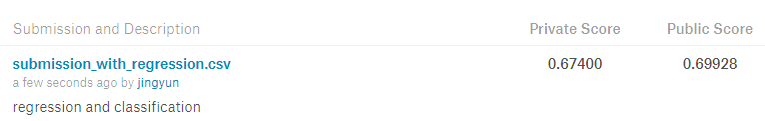

In [30]:
Image(filename= image_path + 'submission_with_regression.PNG') 

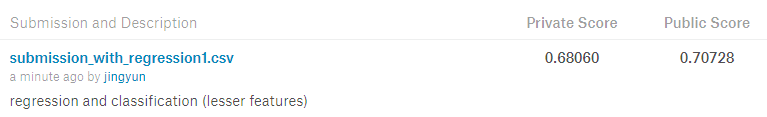

In [44]:
# Resubmitted to kaggle after reducing the features to the top 22 from feature importance
Image(filename= image_path + 'submission_with_regression1.PNG') 

The difference between the private and public kaggle score is small but the difference between the kaggle score and model score is large, indicating that our model is not very accurate.

In [47]:
prediction = model.predict(X_test1)
cm = confusion_matrix(y_test, prediction)  #tn, fp, fn, tp

pd.DataFrame(data=cm, columns=['predicted no wnv', 'predicted wmv'], index=['actual no wnv', 'actual wbv'])

,predicted no wnv,predicted wmv
actual no wnv,2162,463
actual wbv,616,2051
